In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This is where our downloaded images and metadata live locally
DATA_PATH = Path("../training_data")
FEATURE_PATH = DATA_PATH / "train_features"
LABEL_PATH = DATA_PATH / "train_labels"

train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

train_metadata.head()

image_id chip_id flood_id polarization location scene_start
0  awc00_vh   awc00      awc           vh  Bolivia  2018-02-15
1  awc00_vv   awc00      awc           vv  Bolivia  2018-02-15
2  awc01_vh   awc01      awc           vh  Bolivia  2018-02-15
3  awc01_vv   awc01      awc           vv  Bolivia  2018-02-15
4  awc02_vh   awc02      awc           vh  Bolivia  2018-02-15

Text(0.5, 1.0, 'Number of Images by Location')

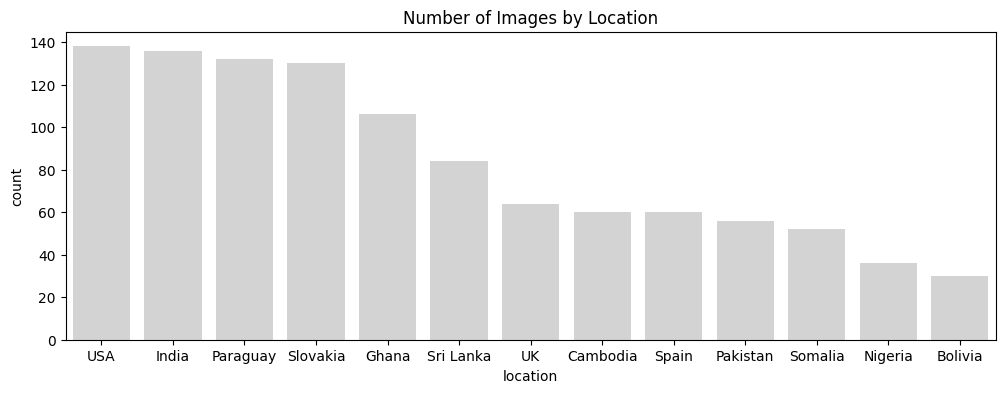

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.countplot(
    x=train_metadata.location,
    order=train_metadata.location.value_counts().index,
    color="lightgray",
)
plt.title("Number of Images by Location")

In [5]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year)["flood_id"].nunique()
year_counts

scene_start
2016    1
2017    2
2018    6
2019    3
2020    1
Name: flood_id, dtype: int64

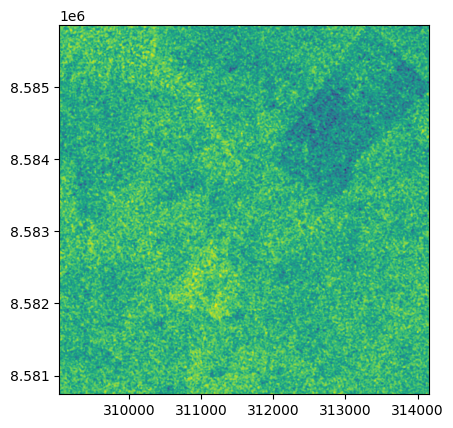

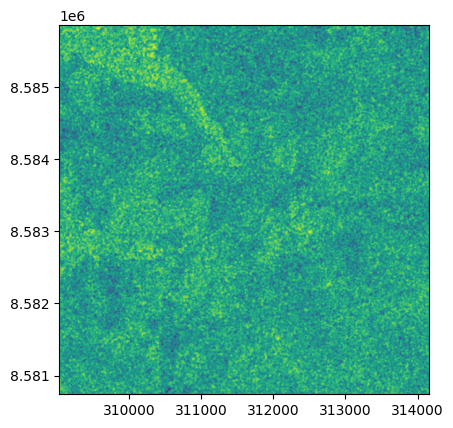

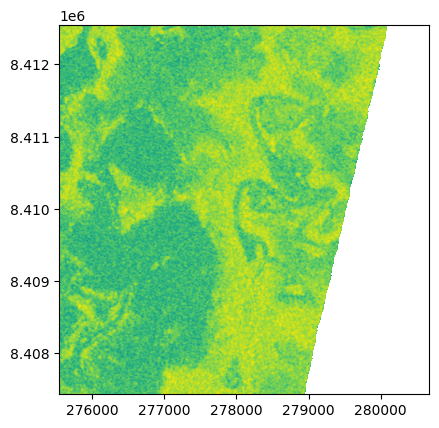

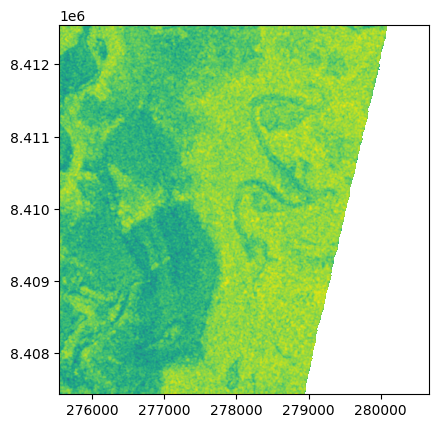

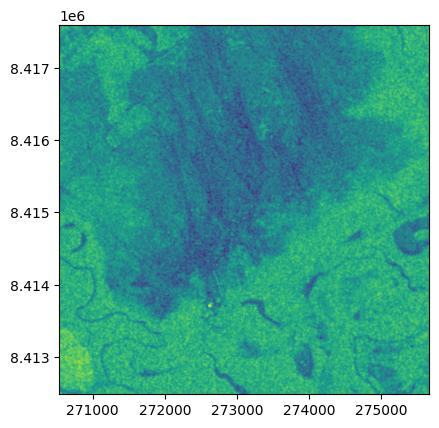

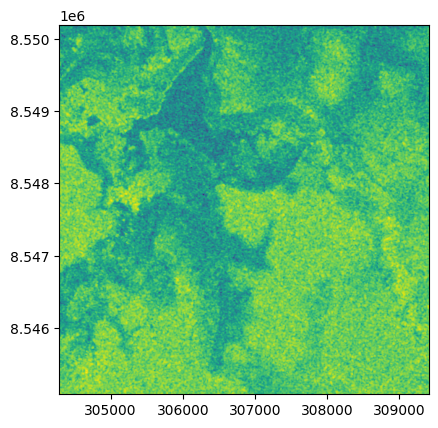

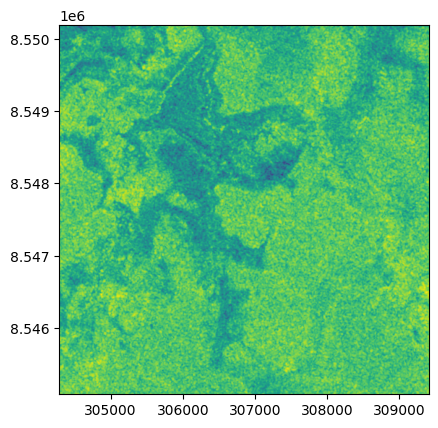

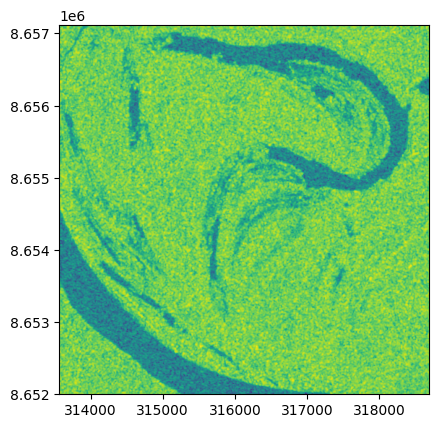

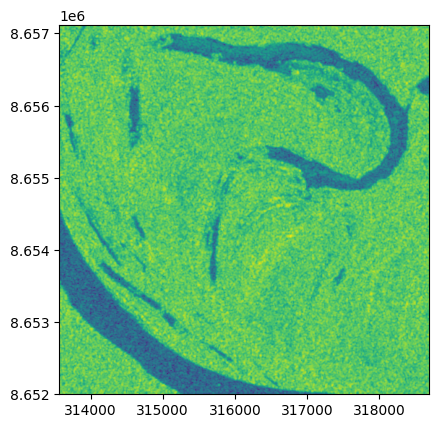

In [6]:
import rasterio
# Display images
from rasterio.plot import show

for i in range(0, 10):
    with rasterio.open(FEATURE_PATH / f"{train_metadata.image_id[i + 10]}.tif") as img:
        show(img)
        data = img.read()

In [7]:
# Examine an arbitrary image
image_path = FEATURE_PATH / f"{train_metadata.image_id[0]}.tif"

with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)  # read a single band

metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [8]:
"""
    Unsigned byte array with the same number of rows and columns as the dataset 
    in which non-zero elements (typically 255) indicate that the 
    corresponding data elements are valid. 
    Other elements are invalid, or nodata elements. 
    The other kind of mask is a numpy.
"""
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [9]:
# Mask value of True indicates invalid data in an array. 

with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)

numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

In [10]:
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])
    
    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    
    # Scaled by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])
    
    # Limit values to 0/1 interval
    return matrix.clip(0, 1)

def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)
        
    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)
    
    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]
    
    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)

def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))
    
    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state = random_state).values[0]
    
    # Extract paths to image files
    vv_path = FEATURE_PATH / f"{random_chip}_vv.tif"
    vh_path = FEATURE_PATH / f"{random_chip}_vh.tif"
    label_path = LABEL_PATH / f"{random_chip}.tif"
    
    print(random_chip)
    
    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)
    
    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

hbe61


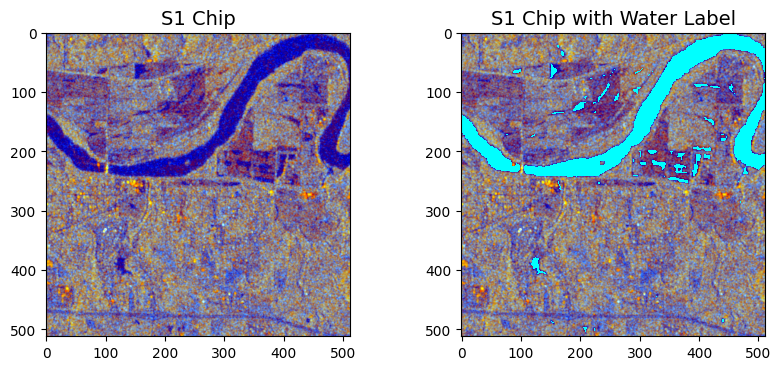

In [11]:
display_random_chip(77)

wvy12


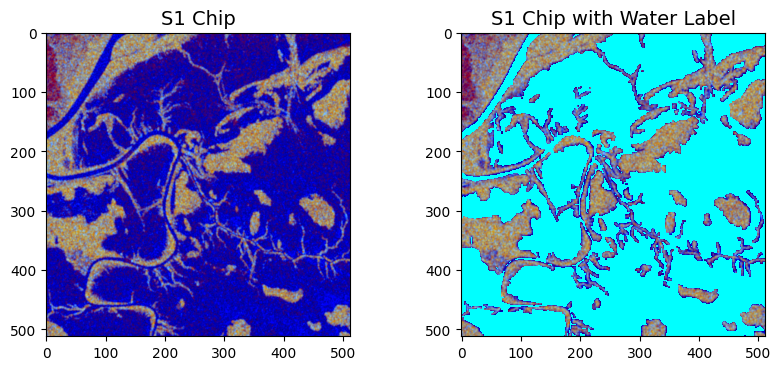

In [12]:
display_random_chip(66)

jja04


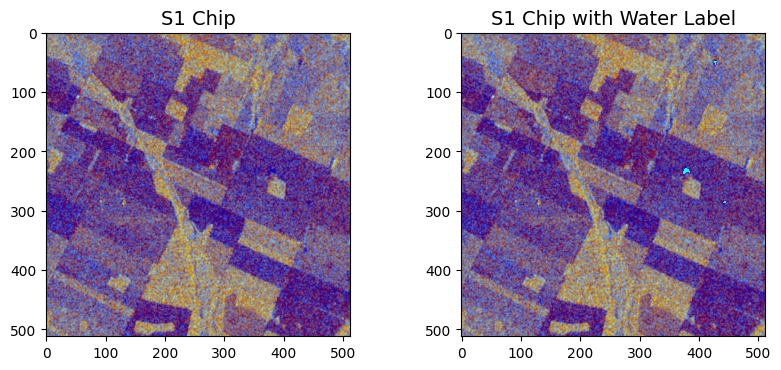

In [18]:
display_random_chip(121212)

In [14]:
# Splitting Data
import random

random.seed(9)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [15]:
val_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)].copy()
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)].copy()

# Confirm approx. 1/3 (33 %) of chips are in the validation set
len(val_df) / (len(val_df) + len(train_df)) * 100

32.47232472324723